In [1]:
%config InlineBackend.figure_format='retina'


In [2]:
import trax.data as data
import trax   
from trax import layers as tl
from trax.supervised import training
import trax.fastmath.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=200)
%matplotlib inline
!pip list | grep trax

trax                     1.3.7


In [3]:
train_stream_fn = data.TFDS('fashion_mnist', 
                            keys=('image', 'label'),
                            data_dir='./data',
                            eval_holdout_size=0.01,  # 1% for eval
                            train=True
                            )
eval_stream_fn = data.TFDS('fashion_mnist', 
                           keys=('image', 'label'),
                           data_dir='./data',
                            eval_holdout_size=0.01,  # 1% for eval
                            train=False
                            )

In [4]:
testdt = train_stream_fn()

In [5]:
a, b = next(testdt)

In [6]:
a.shape

(28, 28, 1)

In [7]:
type(a), type(b)

(numpy.ndarray, numpy.int64)

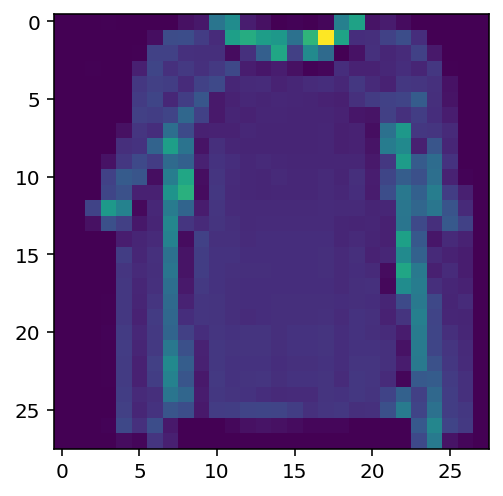

In [8]:
plt.imshow(a)

In [9]:
print(a[:,:,0])
print(b)

[[  0   0   0   1   0   0   0   0  11  16  99 124  20  11   0   2   0   4 111 146  13  19   8   0   0   0   0   0]
 [  0   0   0   0   0   0   9  59  60  45  31 143 157 141 135  95 166 254 147  33  34  49  60  33   0   0   0   0]
 [  0   0   0   0   0   1  49  49  35  34  34   8  35  77 150  48 122  88   0  12  35  27  31  49  17   0   0   0]
 [  0   0   1   0   0  22  53  35  42  35  42  55  20  15  20  11   2   4  33  24  24  28  33  26  41   1   0   0]
 [  0   0   0   0   0  41  48  46  31  49  56  27  30  31  24  27  31  33  28  41  30  24  41  39  35  12   0   0]
 [  0   0   0   0   0  44  53  28  46  68  17  24  28  26  28  27  26  24  22  35  44  49  52  74  34  13   0   0]
 [  0   0   0   0   0  48  46  52  85  49  17  26  24  27  27  26  26  26  24  15  13  48  35  46  33  20   0   0]
 [  0   0   0   0  11  39  33  92  57  23  24  24  28  26  26  26  26  27  22  24   9  95 135  41  39  30   0   0]
 [  0   0   0   0  34  37  81 143  97  13  34  27  26  26  26  26  26  27  22  2

In [10]:
# def pre_process(stream, batch_size):
#     count = 0
#     ib = []
#     tb = []
#     for inputs, targets in stream:
#         count += 1
#         normalized_inputs = inputs / 255.0
#         flatten_inputs = normalized_inputs.flatten()
#         ib.append(flatten_inputs)
#         tb.append(targets)
#         if len(ib) == batch_size:
#             ret_inputs = jnp.array(ib)
#             ret_targets = jnp.array(tb)
#             ret_weights = jnp.ones_like(ret_targets)
#             yield ret_inputs, ret_targets, ret_weights
#             tb = []
#             ib = []
            

In [11]:
batch_size = 32

data_pipeline = data.Serial(
    lambda g: map(lambda pair: (pair[0] / 255.0, pair[1]), g),
    lambda h: map(lambda pair: (pair[0].flatten(), pair[1]), h),
    data.Shuffle(),
    data.Batch(batch_size),
    data.AddLossWeights()
)

In [12]:

# train_stream = pre_process(train_stream_fn(), batch_size)
# eval_stream = pre_process(eval_stream_fn(), batch_size)

train_stream = data_pipeline(train_stream_fn())
eval_stream = data_pipeline(eval_stream_fn())

In [13]:
a, b, m = next(train_stream)
print(a.shape)
print(b.shape)
print(m.shape)

(32, 784)
(32,)
(32,)


In [14]:
input_batch, target_batch, mask_arr = next(train_stream)

# let's see the data type of a batch
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# let's see the shape of this particular batch (batch length, sentence length)
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 784)
target_batch shape:  (32,)


In [15]:
def classifier():
    model = tl.Serial(
        tl.Dense(128),
        tl.Relu(),
        tl.Dense(10),
        tl.LogSoftmax()
    )
    return model

In [16]:
tmp_model = classifier()
print(tmp_model)

Serial[
  Dense_128
  Serial[
    Relu
  ]
  Dense_10
  LogSoftmax
]


In [17]:
from trax.supervised import training

#rnd.seed(271)

train_task = training.TrainTask(
    labeled_data=train_stream,
    loss_layer=tl.WeightedCategoryCrossEntropy(),
    #loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=50,
)

eval_task = training.EvalTask(
    labeled_data=eval_stream,
    # metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
    metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],
)

model = classifier()

In [18]:
import os
!rm -f model/model.pkl.gz
output_dir = 'model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

model/


In [19]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''

    training_loop = training.Loop(
                                classifier,
                                train_task, # The training task
                                eval_tasks = eval_task, # The evaluation task
                                output_dir = output_dir, # The output directory
                                random_seed=31 )

    training_loop.run(n_steps = n_steps)

    return training_loop

In [20]:
training_loop = train_model(model, train_task, eval_task, 250, output_dir_expand)


Step      1: Total number of trainable weights: 101770
Step      1: Ran 1 train steps in 5.63 secs
Step      1: train WeightedCategoryCrossEntropy |  2.47513437
Step      1: eval  WeightedCategoryCrossEntropy |  3.56399488
Step      1: eval      WeightedCategoryAccuracy |  0.12500000

Step     50: Ran 49 train steps in 0.64 secs
Step     50: train WeightedCategoryCrossEntropy |  1.18216193
Step     50: eval  WeightedCategoryCrossEntropy |  0.56566221
Step     50: eval      WeightedCategoryAccuracy |  0.71875000

Step    100: Ran 50 train steps in 0.60 secs
Step    100: train WeightedCategoryCrossEntropy |  0.68381906
Step    100: eval  WeightedCategoryCrossEntropy |  0.59188449
Step    100: eval      WeightedCategoryAccuracy |  0.75000000

Step    150: Ran 50 train steps in 0.60 secs
Step    150: train WeightedCategoryCrossEntropy |  0.63119042
Step    150: eval  WeightedCategoryCrossEntropy |  0.32026398
Step    150: eval      WeightedCategoryAccuracy |  0.87500000

Step    200: Ran 

In [29]:
example_input = next(eval_stream)[0][0]

result = model(example_input[None, :])
print(f'The classification result {jnp.argmax(result)}')
print()
print(example_input.reshape(28,28)*255.0)

The classification result 1

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.  82. 179. 157. 170. 116. 138. 199. 150. 191. 105.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  66. 138. 168. 196. 166. 230. 200. 128. 117.  60.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 105. 186. 200. 183. 171. 161. 167. 189. 178.  95.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 207. 156. 117. 123. 194. 197. 143. 101. 111. 125.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 160. 128. 117. 126. 159. 167. 160. 131. 108.  99.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 143. 139. 123. 140. 199. 210. 179. 150. 129. 114.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 118. 110.  94. 137. 214. 214. 183. 117. 103.  94.   0.   0.   0.  